# **Rice Type Classification**

## 1. Import required files
Di bagian ini, modul-modul yang diperlukan untuk membuat model diimpor. Ini termasuk modul dari TensorFlow, TensorFlow Hub untuk akses ke model yang telah dilatih, dan beberapa modul lainnya untuk visualisasi dan manipulasi data.

In [1]:
# Building deep learning models
import tensorflow as tf 
from tensorflow import keras 
# For accessing pre-trained models
import tensorflow_hub as hub 
# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
import cv2

import os
import numpy as np
import pathlib

from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
import keras
import numpy as np
import matplotlib.cm as cm
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 2. Reading Dataset
 Data beras yang diperlukan dibaca dari direktori `Rice_Image_Dataset`. Sampel gambar untuk setiap jenis beras diambil, dan setiap gambar diberi label berdasarkan jenisnya. Hal ini dilakukan untuk mempersiapkan data untuk pelatihan model.

In [2]:
path = "Rice_Image_Dataset"
path = pathlib.Path(path)

In [3]:
# Mengambil 600 data dari masing-masing jenis beras
arborio = list(path.glob('Arborio/*'))[:600]
basmati = list(path.glob('Basmati/*'))[:600]
ipsala = list(path.glob('Ipsala/*'))[:600]
jasmine = list(path.glob('Jasmine/*'))[:600]
karacadag = list(path.glob('Karacadag/*'))[:600]

In [121]:
data_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
data_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

## 3. Visualisasi Data
Visualisasi ini bertujuan untuk memahami distribusi kelas dalam dataset dan menampilkan contoh gambar untuk setiap jenis beras. Grafik distribusi kelas ditampilkan untuk memahami sebaran jumlah sampel untuk setiap kelas, sementara contoh gambar dari setiap kelas juga ditampilkan.


In [122]:
img = cv2.imread(str(data_images['arborio'][0])) 
img.shape

(250, 250, 3)

In [123]:
# Menghitung jumlah sampel untuk setiap jenis beras
counts = {label: len(images) for label, images in data_images.items()}
rice_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
print("Jumlah sampel untuk setiap jenis beras:")
print(rice_counts)

Jumlah sampel untuk setiap jenis beras:
           Count
arborio      600
basmati      600
ipsala       600
jasmine      600
karacadag    600


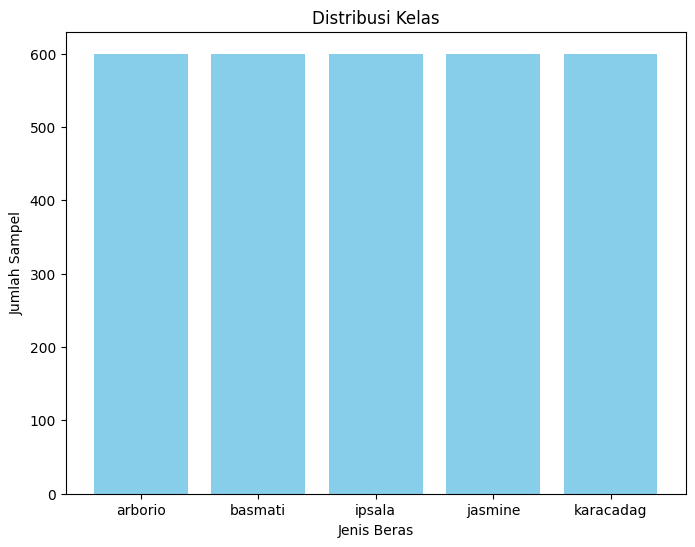

In [124]:
# Menampilkan distribusi kelas
plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values(), color='skyblue')
plt.title('Distribusi Kelas')
plt.xlabel('Jenis Beras')
plt.ylabel('Jumlah Sampel')
plt.show()

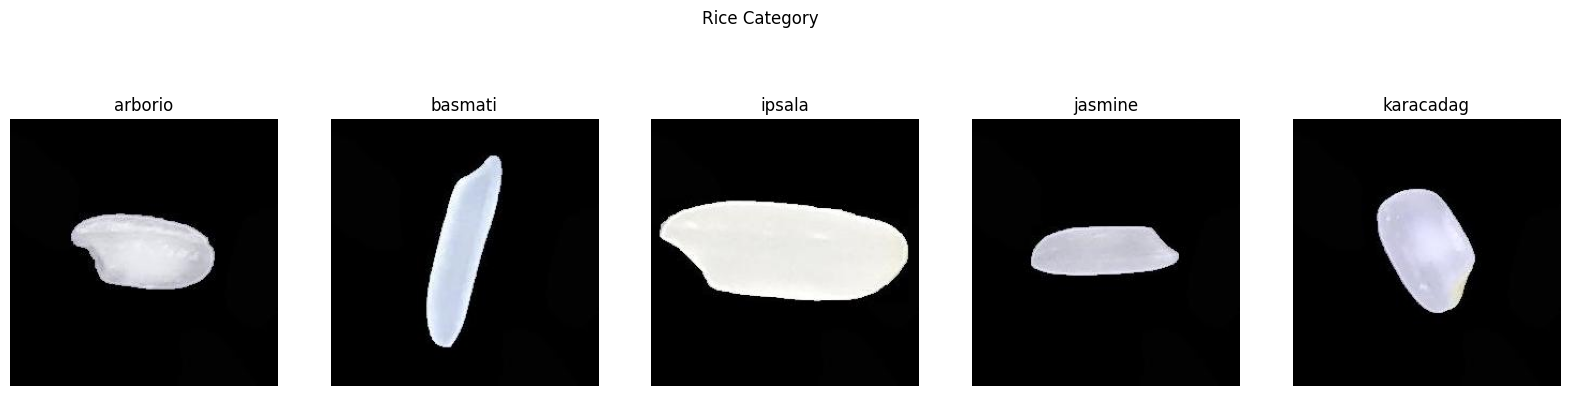

In [125]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category')

# Load dan menampilkan gambar-gambar contoh dari setiap kelas
for i, (label, images) in enumerate(data_images.items()):
    sample_img = mpimg.imread(images[0])  # Gunakan mpimg untuk membaca gambar
    ax[i].set_title(label)
    ax[i].imshow(sample_img)
    ax[i].axis('off')

## 4. Image and label split
Gambar-gambar tersebut kemudian diubah ukurannya menjadi 224x224 dan dibagi menjadi data gambar dan label. Ini akan menjadi input dan output dari model yang akan kita latih.

In [126]:
X, y = [], [] # X = images, y = labels
for label, images in data_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(data_labels[label])

In [127]:
X = np.array(X)
X = X/255
y = np.array(y)

## 5. Data split
Data kemudian dibagi menjadi data pelatihan, pengujian, dan validasi. Ini adalah praktik umum dalam pembelajaran mesin untuk memvalidasi model pada data yang belum pernah dilihat sebelumnya.

In [128]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

## 6. Model Building

### Model 1: MobileNet
MobileNet adalah jaringan neural visi komputer yang dirancang khusus untuk inferensi efisien pada perangkat seluler dengan sumber daya komputasi terbatas. Ini dikembangkan oleh Google dan diperkenalkan dalam makalah tahun 2017 berjudul “MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications”. Model MobileNet didasarkan pada versi sederhana dari arsitektur Inception, yang dikembangkan untuk tugas klasifikasi gambar.

In [129]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [130]:
base_model_mobilenet = MobileNet(weights="imagenet", 
                       include_top=False, 
                       input_shape=(224, 224, 3))

In [131]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model_mobilenet.output_shape[1:]))
top_model.add(Dense(32, activation="relu"))
top_model.add(Dense(10, activation="softmax"))

c:\Users\azzan\.virtualenvs\Rice_classification-3YBHNwwW\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [159]:
transfer_model = Sequential()
transfer_model.add(base_model_mobilenet)
transfer_model.add(top_model)

transfer_model.layers[0].trainable = False

transfer_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


history = transfer_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5


c:\Users\azzan\.virtualenvs\Rice_classification-3YBHNwwW\Lib\site-packages\keras\src\backend\tensorflow\nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - acc: 0.9981 - loss: 0.0119 - val_acc: 0.9947 - val_loss: 0.0113
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step - acc: 0.9920 - loss: 0.0316 - val_acc: 0.9947 - val_loss: 0.0343
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 240ms/step - acc: 0.9968 - loss: 0.0095 - val_acc: 1.0000 - val_loss: 8.8152e-04
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - acc: 0.9995 - loss: 0.0032 - val_acc: 1.0000 - val_loss: 0.0034
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - acc: 1.0000 - loss: 3.8511e-04 - val_acc: 1.0000 - val_loss: 0.0018


### Evaluation
Setelah pelatihan selesai, kita mengevaluasi model dengan menggunakan data uji untuk mengukur akurasinya. Hasil evaluasi disimpan dalam variabel history untuk digunakan dalam visualisasi. Visualisasi dilakukan untuk menampilkan training accuracy, validation accuracy, training loss, dan validation loss.

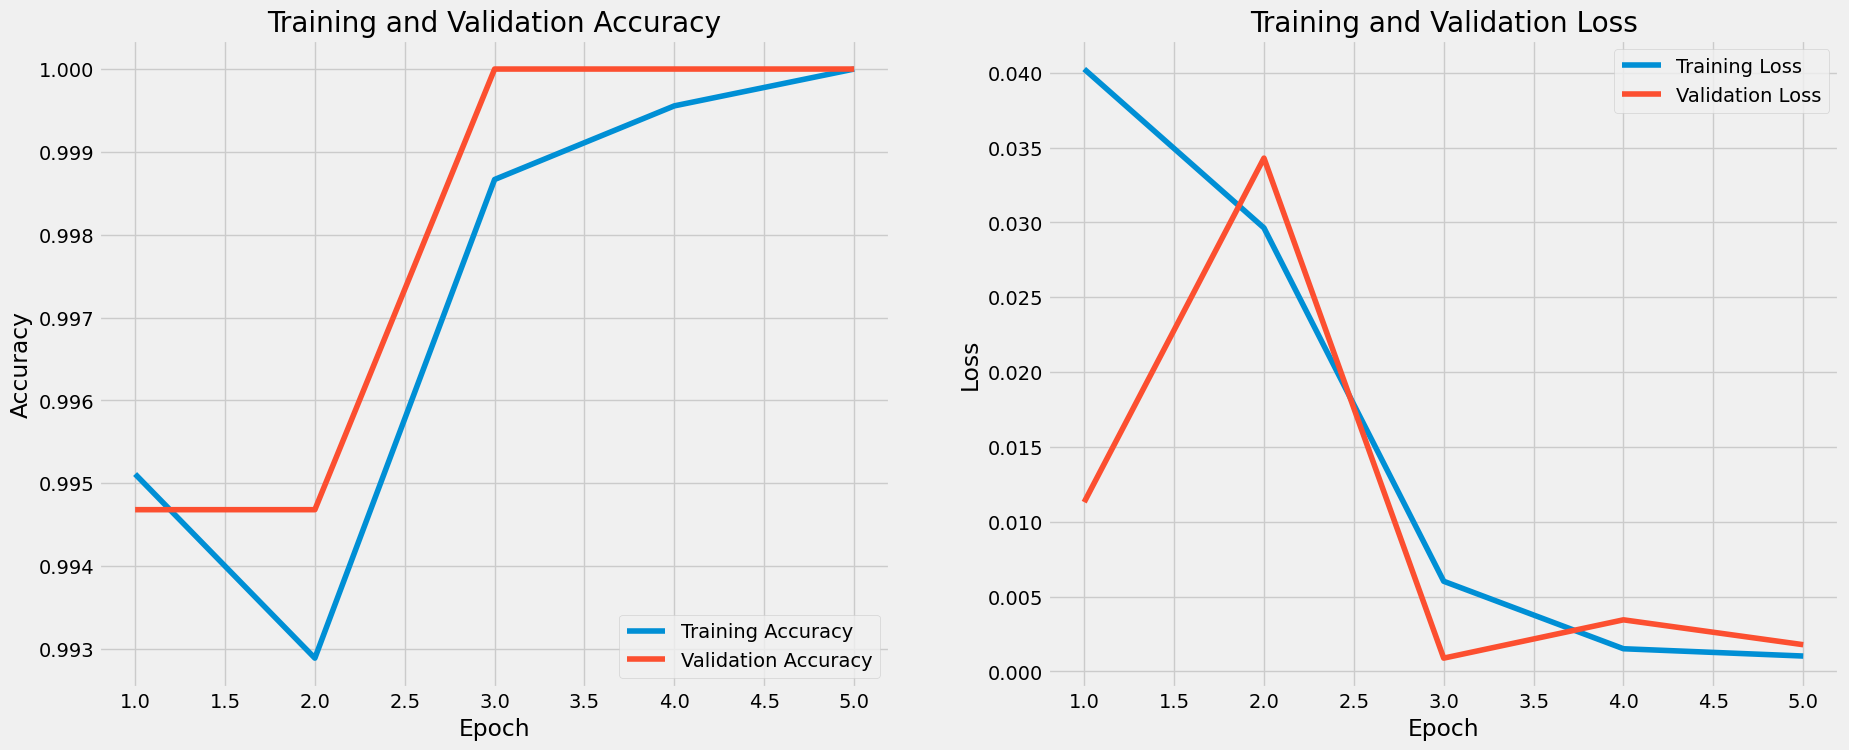

In [160]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


In [161]:
# Menampilkan laporan klasifikasi
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji menggunakan model MobileNet
y_pred_mobilenet = transfer_model.predict(X_test)
y_pred_mobilenet = np.argmax(y_pred_mobilenet, axis=1)

# Menampilkan laporan klasifikasi untuk model MobileNet
classificationReport_mobilenet = classification_report(y_test, y_pred_mobilenet)
print(f'Laporan Klasifikasi untuk MobileNet:\n{classificationReport_mobilenet}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step
Laporan Klasifikasi untuk MobileNet:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      0.99      0.99       100
           2       1.00      1.00      1.00       134
           3       0.99      1.00      1.00       111
           4       1.00      1.00      1.00        99

    accuracy                           1.00       562
   macro avg       1.00      1.00      1.00       562
weighted avg       1.00      1.00      1.00       562



Semua kelas memiliki nilai precision, recall, dan f1-score yang sangat tinggi, mendekati atau mencapai 1. Hal ini menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam mengklasifikasikan setiap kelas tanpa banyak kesalahan.

In [158]:
results = transfer_model.evaluate(X_test, y_test, verbose=0)

print("    Loss Pengujian: {:.5f}".format(results[0]))
print("Akurasi Pengujian: {:.2f}%".format(results[1] * 100))

    Loss Pengujian: 0.00085
Akurasi Pengujian: 100.00%


Model MobileNet yang dilatih memiliki performa yang sangat baik dalam mengklasifikasikan jenis-jenis beras, dengan akurasi 100% pada data uji. Hal ini menunjukkan bahwa model ini dapat diandalkan untuk digunakan dalam aplikasi praktis untuk klasifikasi beras.

### Model 2: VGG
VGG16 adalah jaringan saraf konvolusional yang digunakan untuk tugas klasifikasi gambar, pengenalan gambar, dan deteksi objek. Ini menggunakan arsitektur 16 lapisan dan mampu mengklasifikasikan gambar ke dalam 1.000 kategori berbeda dengan akurasi tinggi.

In [163]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [164]:
# Membuat model VGG16
base_model_vgg16 = VGG16(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))

In [152]:
# Membuat model top (layer yang ditambahkan di atas VGG16)
top_model_vgg16 = Sequential()
top_model_vgg16.add(Flatten(input_shape=base_model_vgg16.output_shape[1:]))
top_model_vgg16.add(Dense(32, activation='relu'))
top_model_vgg16.add(Dense(5, activation='softmax'))  # 5 kelas untuk dataset ini

In [165]:
# Menggabungkan model VGG16 dengan top model
model_vgg16 = Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(top_model_vgg16)

# Mengatur agar layer pada model VGG16 menjadi tidak dapat di-train
model_vgg16.layers[0].trainable = False

# Mengompilasi model
model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melatih model dengan data yang telah diproses sebelumnya
history_vgg16 = model_vgg16.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.9857 - loss: 0.0704 - val_accuracy: 1.0000 - val_loss: 0.0489
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.9941 - loss: 0.0390 - val_accuracy: 0.9947 - val_loss: 0.0378
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.9918 - loss: 0.0373 - val_accuracy: 0.9947 - val_loss: 0.0352
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9941 - loss: 0.0286 - val_accuracy: 0.9947 - val_loss: 0.0261
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9972 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0218


### Evaluation

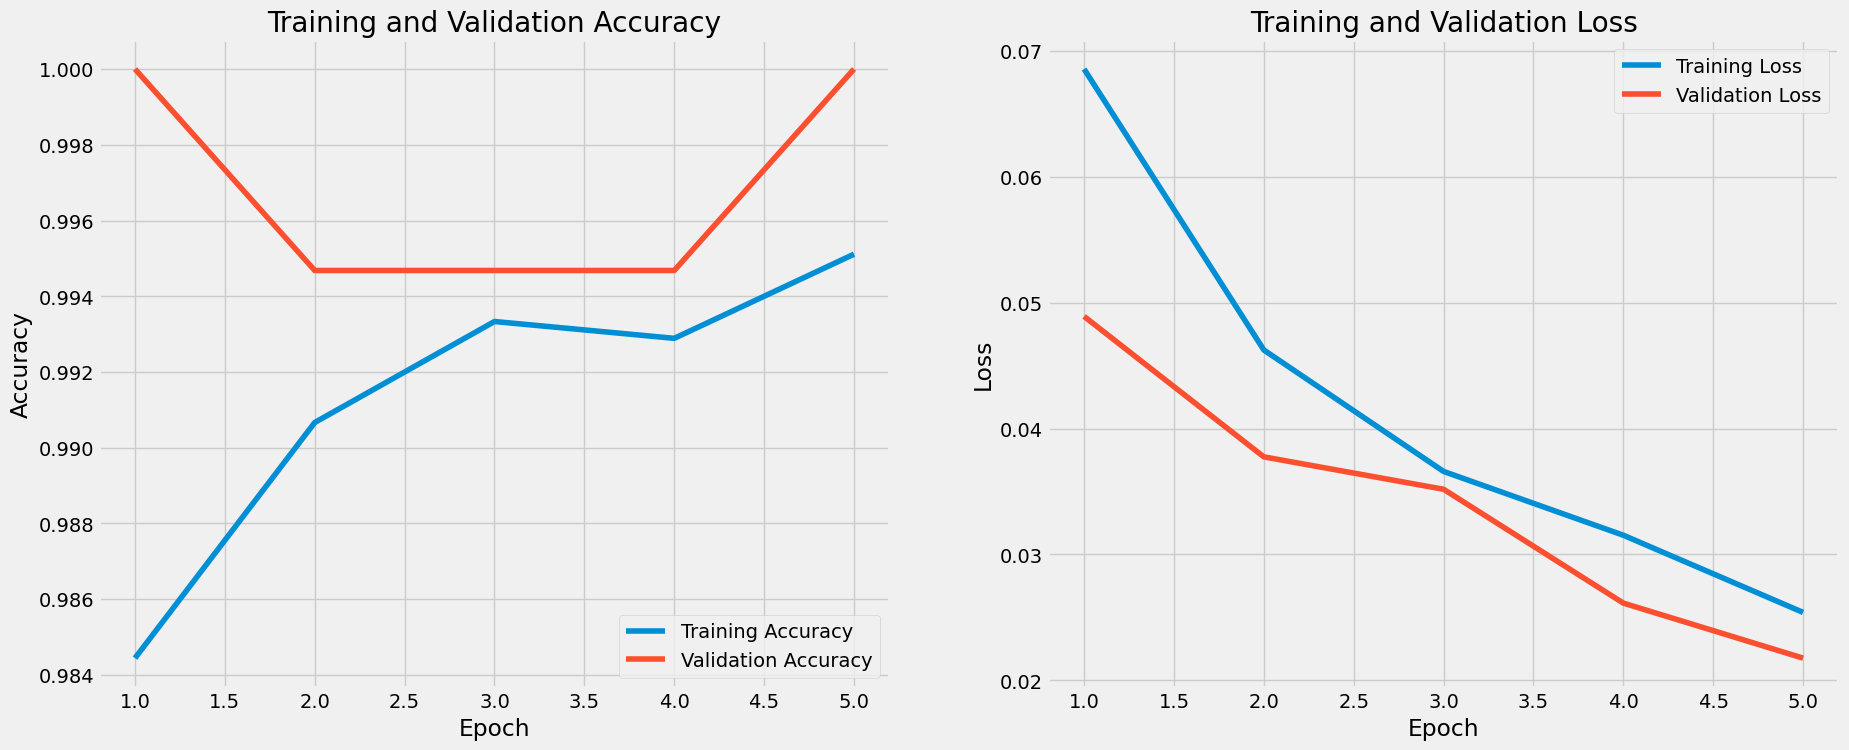

In [171]:
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_vgg16, label='Training Accuracy')
plt.plot(epochs_range, val_acc_vgg16, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_vgg16, label='Training Loss')
plt.plot(epochs_range, val_loss_vgg16, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [169]:
# Menampilkan laporan klasifikasi
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji menggunakan model VGG16
y_pred_vgg16 = model_vgg16.predict(X_test)
y_pred_vgg16 = np.argmax(y_pred_vgg16, axis=1)

# Menampilkan laporan klasifikasi untuk model VGG16
classificationReport_vgg16 = classification_report(y_test, y_pred_vgg16)
print(f'Laporan Klasifikasi untuk VGG16:\n{classificationReport_vgg16}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
Laporan Klasifikasi untuk VGG16:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       118
           1       0.99      0.99      0.99       100
           2       1.00      1.00      1.00       134
           3       0.98      0.99      0.99       111
           4       1.00      1.00      1.00        99

    accuracy                           0.99       562
   macro avg       0.99      0.99      0.99       562
weighted avg       0.99      0.99      0.99       562



In [170]:
# Evaluasi model pada data uji
test_loss, test_acc = model_vgg16.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9973 - loss: 0.0184
Test Accuracy: 0.9946619272232056
Test Loss: 0.028327081352472305


Output menunjukkan bahwa model VGG16 memiliki akurasi sebesar 99.47% dan loss sebesar 0.0184 pada data uji, yang menunjukkan bahwa model ini mampu dengan baik dalam mengklasifikasikan data baru yang belum pernah dilihat sebelumnya.

## Komparasi

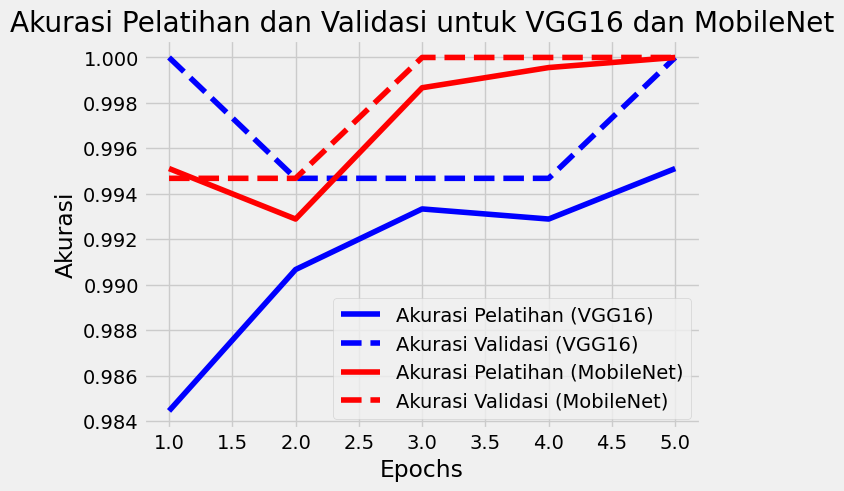

In [172]:
# Evaluation of the two models
import matplotlib.pyplot as plt

# Mengekstrak akurasi dan validasi akurasi model VGG16
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']

# Mengekstrak akurasi dan validasi akurasi model MobileNet
acc_mobilenet = history.history['acc']
val_acc_mobilenet = history.history['val_acc']

# Epochs untuk masing-masing model
epochs_vgg16 = range(1, len(acc_vgg16) + 1)  # Epochs untuk VGG16
epochs_mobilenet = range(1, len(acc_mobilenet) + 1)  # Epochs untuk MobileNet

# Plotting akurasi pelatihan dan validasi untuk VGG16
plt.plot(epochs_vgg16, acc_vgg16, 'b-', label='Akurasi Pelatihan (VGG16)')
plt.plot(epochs_vgg16, val_acc_vgg16, 'b--', label='Akurasi Validasi (VGG16)')

# Plotting akurasi pelatihan dan validasi untuk MobileNet
plt.plot(epochs_mobilenet, acc_mobilenet, 'r-', label='Akurasi Pelatihan (MobileNet)')
plt.plot(epochs_mobilenet, val_acc_mobilenet, 'r--', label='Akurasi Validasi (MobileNet)')

plt.title('Akurasi Pelatihan dan Validasi untuk VGG16 dan MobileNet')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()

plt.show()

## Prediksi

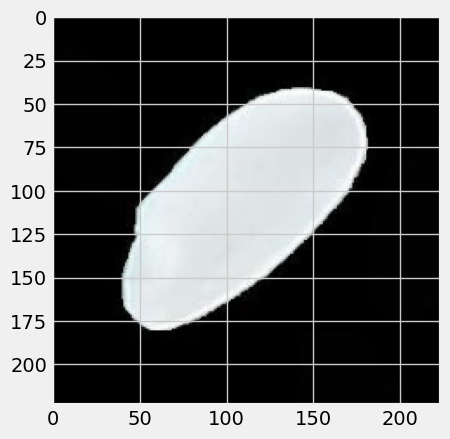

Label yang benar adalah: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Nilai yang diprediksi adalah: [5.7183710e-28 6.5638005e-21 1.0000000e+00 0.0000000e+00 3.4450210e-32
 0.0000000e+00 8.1390419e-37 5.3570315e-22 0.0000000e+00 0.0000000e+00]
Label yang diprediksi adalah: 2
Rice Type yang diprediksi adalah: ipsala
Prediksi benar


In [175]:
import random

n = random.randint(0, 200) # Jangan melampaui (jumlah gambar test - 1)

plt.imshow(X_test[n])
plt.show()

label_benar = y_test[n]
print("Label yang benar adalah:", label_benar)

prediksi = transfer_model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:", prediksi)

label_prediksi = np.argmax(prediksi)
print("Label yang diprediksi adalah:", label_prediksi)

label_dict = {v: k for k, v in data_labels.items()}  # Membuat kamus label

print("Rice Type yang diprediksi adalah:", label_dict[label_prediksi])

if label_benar == label_prediksi:
    print("Prediksi benar")
else:
    print("Prediksi salah")